In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data Pipeline Preprocessing

In [2]:
trans_df = pd.read_csv('/Users/mehrnazuser/Documents/Lavoro/BlueRockLogistics/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';', encoding = 'utf-8')
#Type_List = ['COL', 'RET']
#trans_df = trans_df.loc[trans_df['T_DOC_TYPE'].isin(Type_List)]
trans_df = trans_df.loc[trans_df['T_DOC_TYPE'] == 'COL']

trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.dropna(subset = ['Date'])

trans_df = trans_df[['Date', 'T_DOC_TYPE', 'T_SENDING_ID', 'T_RTI_NAME', 'T_ACT_HAND_OUT_QTY']]
trans_df = trans_df.reset_index()
trans_df = trans_df.drop('index', axis = 1)
#trans_df.head()

In [3]:
depot_add = pd.read_excel('/Users/mehrnazuser/Documents/Lavoro/BlueRockLogistics/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
depot_add = depot_add[['name', 'code', 'country']]
#depot_add.head()

In [4]:
# JOIN

trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop(['T_SENDING_ID', 'T_DOC_TYPE'], axis =1)
trans_full.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name,country
0,2014-12-22,CC Euro Container Base,60,NL-Bleiswijk-CCNL,NL
1,2014-12-22,CC Euro Container Post 170,240,NL-Bleiswijk-CCNL,NL
2,2014-07-09,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL
3,2014-07-09,CC Container Shelf,30,NL-Bleiswijk Bloemenveiling Holland,NL
4,2014-07-04,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL


In [5]:
trans_nl = trans_full.loc[trans_full['country'] == 'NL']
trans_nl = trans_nl.sort_values('Date', ascending = True)
trans_nl = trans_nl.drop(['country'], axis = 1)
trans_nl.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name
40927,2014-07-01,CBL 7,3250,NL-Zwaagdijk Vijn
2502,2014-07-01,CBL 7,3000,NL-Zwaagdijk Vijn
4766,2014-07-01,Chep blok,26,NL-Zwaagdijk Vijn
1709,2014-07-01,CBL 7,3250,NL-Zwaagdijk Vijn
1708,2014-07-01,CBL 7,3250,NL-Zwaagdijk Vijn


In [6]:
nl_cb = trans_nl.loc[trans_nl['T_RTI_NAME'] == 'CC Container Base']
nl_cb = nl_cb.drop(['T_RTI_NAME'], axis = 1)
nl_cb['Date'] = pd.to_datetime(nl_cb['Date'])
nl_cb = nl_cb.set_index('Date')
#nl_cb

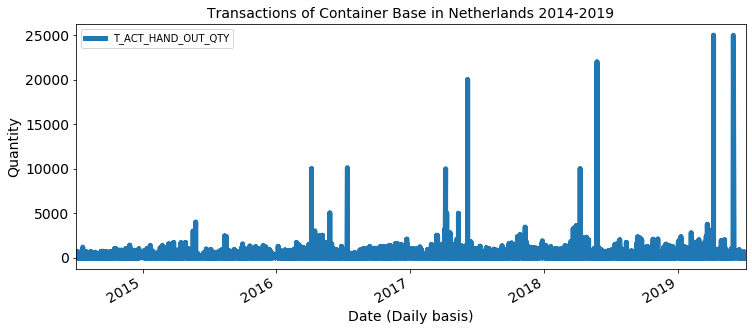

In [7]:
nl_cb.plot(figsize=(12,5), linewidth=5, fontsize=14)
plt.title("Transactions of Container Base in Netherlands 2014-2019", fontsize = 14)
plt.xlabel('Date (Daily basis)', fontsize = 14)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

## Monthly from 2016 on

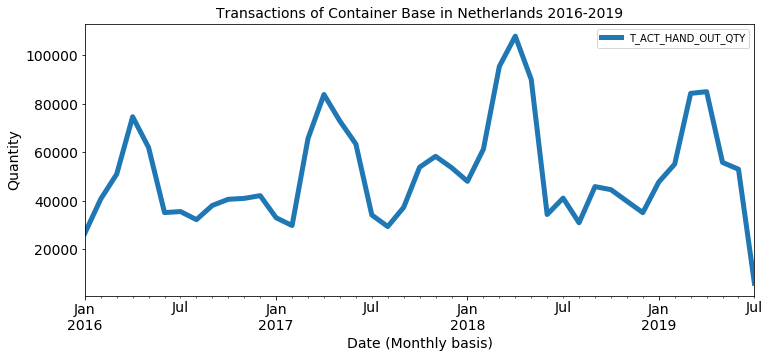

In [8]:
import datetime
nl_cbm = nl_cb.resample('1M').sum()
nl_cb_m = nl_cbm[(nl_cbm.index >= datetime.datetime(2016,1,31))]
nl_cb_m.plot(figsize=(12,5), linewidth=5, fontsize=14)
plt.title("Transactions of Container Base in Netherlands 2016-2019", fontsize = 14)
plt.xlabel('Date (Monthly basis)', fontsize = 14)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

## Seasonal Decompose

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
result = seasonal_decompose(nl_cb_m, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

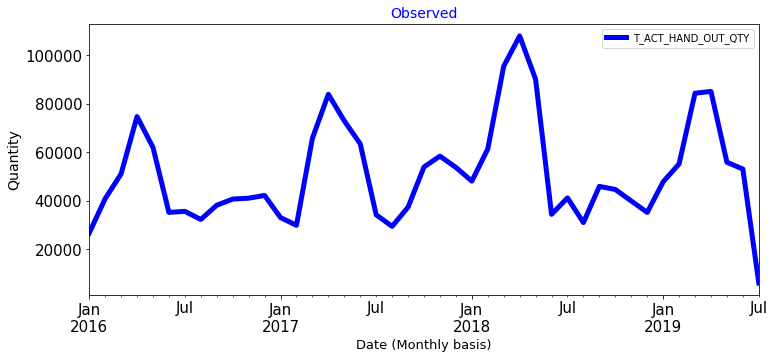

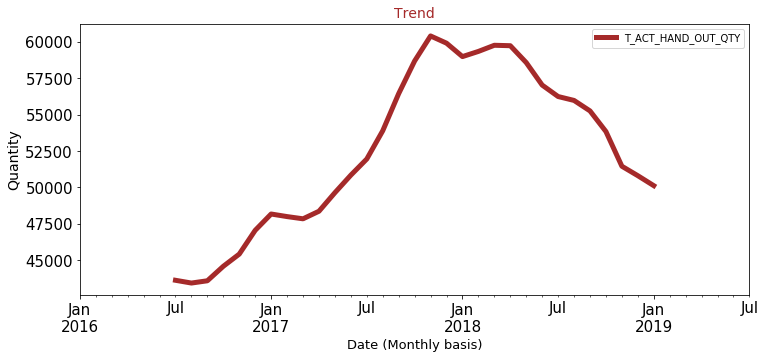

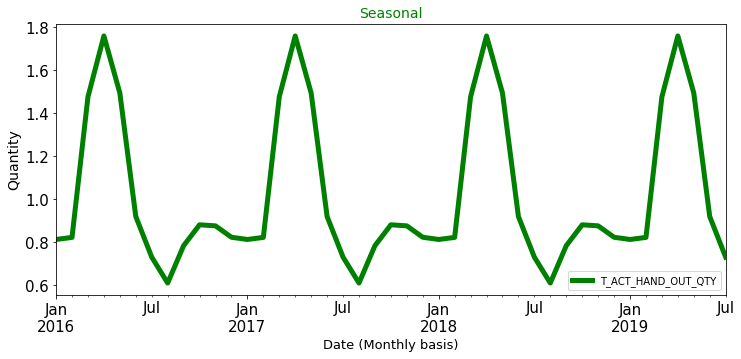

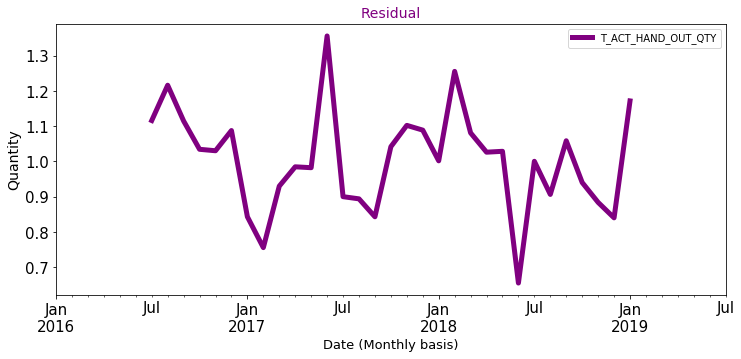

In [10]:
result.observed.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'blue')
plt.title('Observed', fontsize = 14, color ='blue')
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

result.trend.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'brown')
plt.title('Trend', fontsize = 14 , color = 'brown')
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

result.seasonal.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'green')
plt.title('Seasonal', fontsize = 14 , color = 'green')
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

result.resid.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'purple')
plt.title('Residual', fontsize = 14 , color = 'purple')
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

## SARIMA

In [11]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
stepwise_model = arima.auto_arima(nl_cb_m, start_p=1, start_q=1,
                           max_p=6, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=685.738, BIC=688.541, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=673.002, BIC=678.607, Fit time=0.069 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=684.034, BIC=685.436, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=681.912, BIC=686.116, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 12); AIC=674.936, BIC=681.942, Fit time=0.176 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=na

In [12]:
#it_cb_m.index

In [13]:
train = nl_cb_m.loc['2016-01-31':'2018-12-31']
test = nl_cb_m.loc['2019-01-31':]

In [14]:
model_fit = stepwise_model.fit(train)
model_fit

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [15]:
future_forecast = stepwise_model.predict(n_periods=7)
future_forecast

array([33283.63968188, 35297.26180383, 68149.35785848, 81482.22494447,
       65180.44647552, 32584.44785049, 17401.05640642])

Text(0.5, 1.0, '2019 Prediction of FR-CB')

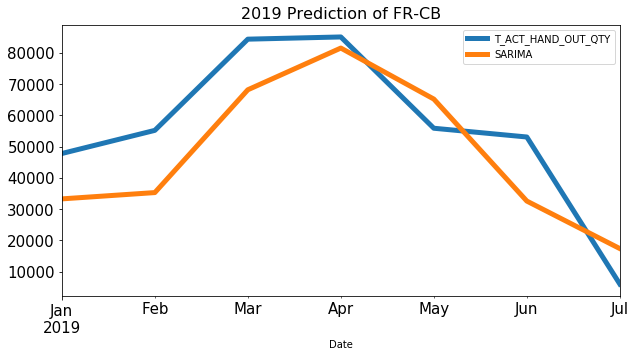

In [16]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['SARIMA'])
pd.concat([test,future_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of FR-CB', fontsize = 16)

In [17]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, future_forecast)
mse

216345287.09110424

In [18]:
model_fit.aic

<function pmdarima.arima.arima.ARIMA.aic(self)>

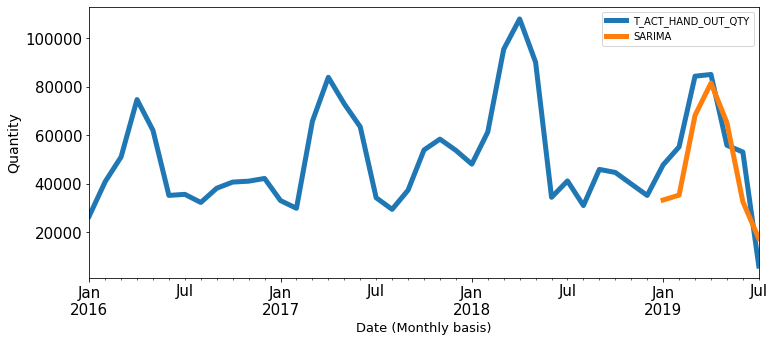

In [19]:
pd.concat([nl_cb_m,future_forecast],axis=1).plot(figsize=(12,5), linewidth=5, fontsize=15)
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

## ARIMA

In [20]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
arima_model = arima.auto_arima(nl_cb_m, start_p=0, start_q=0,
                           max_p=5, max_q=5,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(arima_model.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=948.777, BIC=952.252, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=948.247, BIC=953.460, Fit time=0.013 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=948.093, BIC=953.306, Fit time=0.013 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=946.818, BIC=948.556, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=950.026, BIC=956.977, Fit time=0.025 seconds
Total fit time: 0.071 seconds
946.8180753300524


In [21]:
arima_fit = arima_model.fit(train)

In [22]:
arima_forecast = arima_fit.predict(n_periods=7)
arima_forecast

array([35170., 35170., 35170., 35170., 35170., 35170., 35170.])

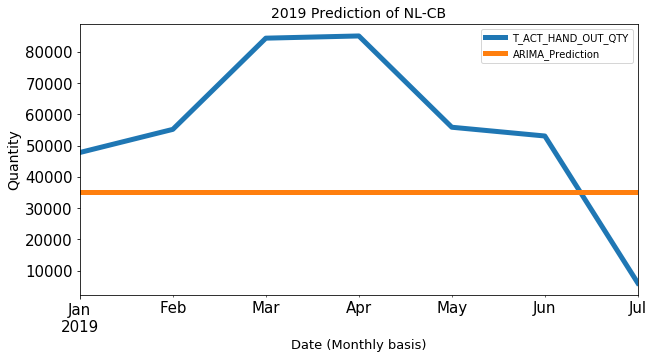

In [23]:
arima_forecast = pd.DataFrame(arima_forecast,index = test.index,columns=['ARIMA_Prediction'])
pd.concat([test,arima_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of NL-CB', fontsize = 14)
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

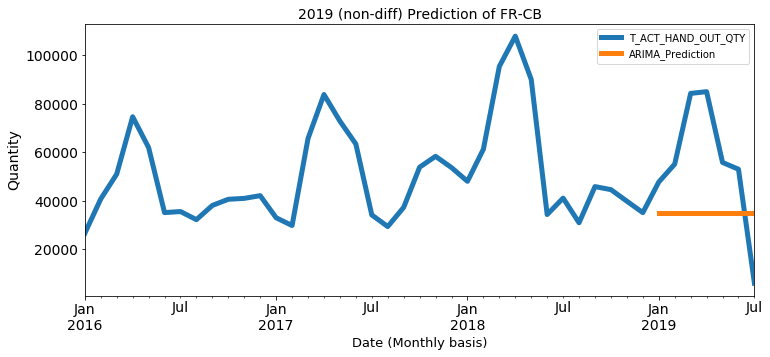

In [24]:
pd.concat([nl_cb_m, arima_forecast],axis=1).plot(figsize=(12,5), linewidth=5, fontsize=14)
plt.title('2019 (non-diff) Prediction of FR-CB', fontsize = 14)
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

In [25]:
arima_mse = mean_squared_error(test, arima_forecast)
arima_mse

1008121609.7142857

## ARMA

In [ ]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
nodiff_model = arima.auto_arima(nl_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(nodiff_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=963.529, BIC=972.335, Fit time=0.057 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=981.512, BIC=985.034, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=961.345, BIC=968.390, Fit time=0.071 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=965.469, BIC=972.513, Fit time=0.034 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=1063.094, BIC=1064.856, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=965.693, BIC=970.976, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=962.555, BIC=971.361, Fit time=0.099 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=963.263, BIC=972.069, Fit time=0.052 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=963.223, BIC=970.268, Fit time=0.024 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2

In [ ]:
nodiff_fit = nodiff_model.fit(train)

In [ ]:
nondiff_forecast = nodiff_fit.predict(n_periods=7)
nondiff_forecast

In [ ]:
nondiff_forecast = pd.DataFrame(nondiff_forecast,index = test.index,columns=['ARMA_Prediction'])
pd.concat([test,nondiff_forecast],axis=1).plot(figsize=(12,5), linewidth=5, fontsize=14)
plt.title('2019 Prediction of NL-CB', fontsize = 16)
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

In [ ]:
nondiff_mse = mean_squared_error(test, nondiff_forecast)
nondiff_mse

In [ ]:
pd.concat([nl_cb_m,nondiff_forecast],axis=1).plot(figsize=(12,5), linewidth=5, fontsize=14)
plt.title('2019 (non-diff) Prediction of NL-CB', fontsize = 14)
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

## Comparison

In [ ]:
pd.concat([nl_cb_m, nondiff_forecast, future_forecast, arima_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='Netherlands')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Date (Monthly basis)', fontsize = 13)
plt.ylabel('Quantity', fontsize = 14)
plt.show()

In [ ]:
MSEs = [mse, nondiff_mse, arima_mse]

In [ ]:
if (min(MSEs) == mse):
    print('\n SARIMA model (Green Line) is the most accurate one here.\n')
elif (min(MSEs) == nondiff_mse):
        print('\n ARMA model (Blue Line) is the most accurate one here.\n')
elif (min(MSEs) == arima_mse):
        print('\n ARIMA model (Red Line) is the most accurate one here.\n')